# Neural Network

## Load Data

In [35]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

## Check Point

In [5]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [54]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [133]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

In [134]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l1_b, p_l2_w, p_l2_b):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l1_b = p_l1_b
        self.p_l2_w = p_l2_w
        self.p_l2_b = p_l2_b
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None, 10], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l1_b = tf.Variable(self.p_l1_b, dtype=tf.float32, name='l1_b')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')
        self.l2_b = tf.Variable(self.p_l2_b, dtype=tf.float32, name='l2_b')

    def build(self):
        l1_a = selu(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        logits = tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b)
        return logits

In [135]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [136]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

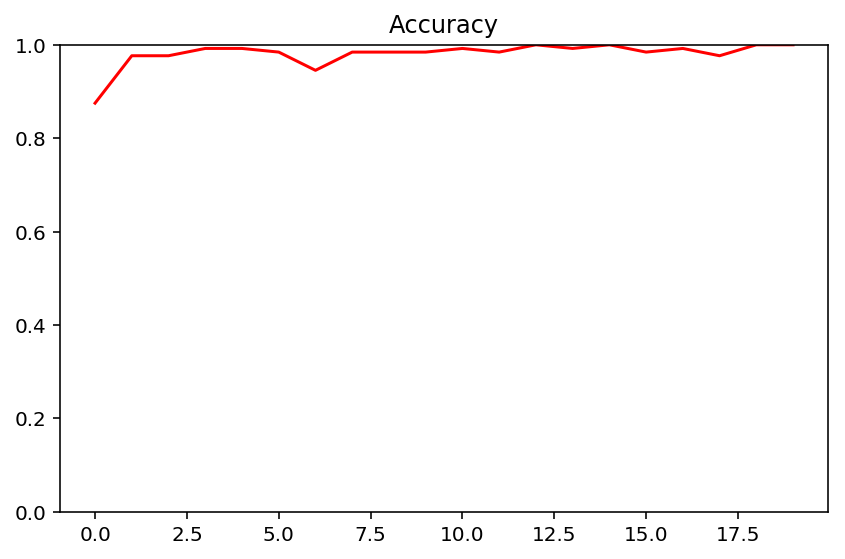

In [137]:
batch_size = 128
x_dim = 784
n_classes = 10
epochs = 20

with tf.Session() as sess:
    
    l1_w = [[truncated_normal() for _ in range(100)] for _ in range(x_dim)]
    l1_b = np.zeros(100)
    l2_w = [[truncated_normal() for _ in range(10)] for _ in range(100)]
    l2_b = np.zeros(10)

    net = Network(x_dim, n_classes, l1_w, l1_b, l2_w, l2_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        batch_num = mnist.train.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.train.next_batch(batch_size)
            train_batch = train_batch*2-1

            # Run optimizers
            feed_dict = {net.x:train_batch,
                         net.y:labels}
            _ = sess.run([net.optimizer], feed_dict=feed_dict)
            logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
            
        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [156]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [157]:
__DEBUG__ = False
batch_size = 64
x_dim = 784
n_classes = 10

In [163]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
    def generate(self):
        self.gene = {}
        # l1_w 
        self.gene[0] = np.array([[truncated_normal() for _ in range(100)] for _ in range(x_dim)])
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.array([[truncated_normal() for _ in range(10)] for _ in range(100)])
        # l2_b 
        self.gene[3] = np.random.randn(10)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          n_classes,
                          self.gene[0],
                          self.gene[1], 
                          self.gene[2], 
                          self.gene[3])
            sess.run(tf.global_variables_initializer())
            
            values = []
            batch_num = mnist.train.num_examples//batch_size
            for ii in range(batch_num):
                train_batch, labels = mnist.train.next_batch(batch_size)
                # Run optimizers
                feed_dict = {net.x: train_batch,
                             net.y: labels}
                values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent, recombination_probability=.5):
        child = {}
        # Complete Continuous Recombination
        child[0] = self.gene[0][:]
        child[1] = self.gene[1][:]
        child[2] = self.gene[2][:]
        child[3] = self.gene[3][:]
        
        prob = np.random.sample()
        if prob <= recombination_probability:
            child[0] = (child[0][:] + parent.gene[0][:])/2.
            
        prob = np.random.sample()
        if prob <= recombination_probability:
            child[1] = (child[1][:] + parent.gene[1][:])/2.
            
        prob = np.random.sample()
        if prob <= recombination_probability:
            child[2] = (child[2][:] + parent.gene[2][:])/2.
            
        prob = np.random.sample()
        if prob <= recombination_probability:
            child[3] = (child[3][:] + parent.gene[3][:])/2.
        
        ''' 
        # Continuous Recombination
        for ii, g in enumerate(child[0]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[0][ii] = (g + parent.gene[0][ii])/2.
    
        for ii, g in enumerate(child[1]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[1][ii] = (g + parent.gene[1][ii])/2.
        
        for ii, g in enumerate(child[2]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[2][ii] = (g + parent.gene[2][ii])/2.
        
        for ii, g in enumerate(child[3]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[3][ii] = (g + parent.gene[3][ii])/2.
        '''
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate=.05):
        prob = np.random.sample()

        if prob <= mutation_rate:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              n_classes,
                              self.gene[0],
                              self.gene[1], 
                              self.gene[2], 
                              self.gene[3])
                sess.run(tf.global_variables_initializer())
                
                batch_num = mnist.train.num_examples//batch_size
                for ii in range(batch_num):
                    train_batch, labels = mnist.train.next_batch(batch_size)
                    # Run optimizers
                    feed_dict = {net.x: train_batch,
                                 net.y: labels}
                    _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = sess.run(net.l1_w)
                self.gene[1] = sess.run(net.l1_b)
                self.gene[2] = sess.run(net.l2_w)
                self.gene[3] = sess.run(net.l2_b)
        

In [164]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [172]:
# hypter-parameters
max_generations = 1
population_size = 20
mutation_rate = 1.

In [173]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual, population

1/20, Accuracy 0.10346332937479019
2/20, Accuracy 0.09236758202314377
3/20, Accuracy 0.1104481965303421
4/20, Accuracy 0.0914035215973854
5/20, Accuracy 0.07765206694602966
6/20, Accuracy 0.08598297089338303
7/20, Accuracy 0.08083527535200119
8/20, Accuracy 0.0883658304810524
9/20, Accuracy 0.04356446489691734
10/20, Accuracy 0.15868742763996124
11/20, Accuracy 0.08121725916862488
12/20, Accuracy 0.10299039632081985
13/20, Accuracy 0.1802968531847
14/20, Accuracy 0.09227663278579712
15/20, Accuracy 0.11012078076601028
16/20, Accuracy 0.07174039632081985
17/20, Accuracy 0.095732681453228
18/20, Accuracy 0.08272700756788254
19/20, Accuracy 0.10791981965303421
20/20, Accuracy 0.06693830341100693
Generation: 1/1, Solution accuracy: 0.1802968531847

Completed 1 generations:
Final accuracy: 0.1802968531847, Generation: 0


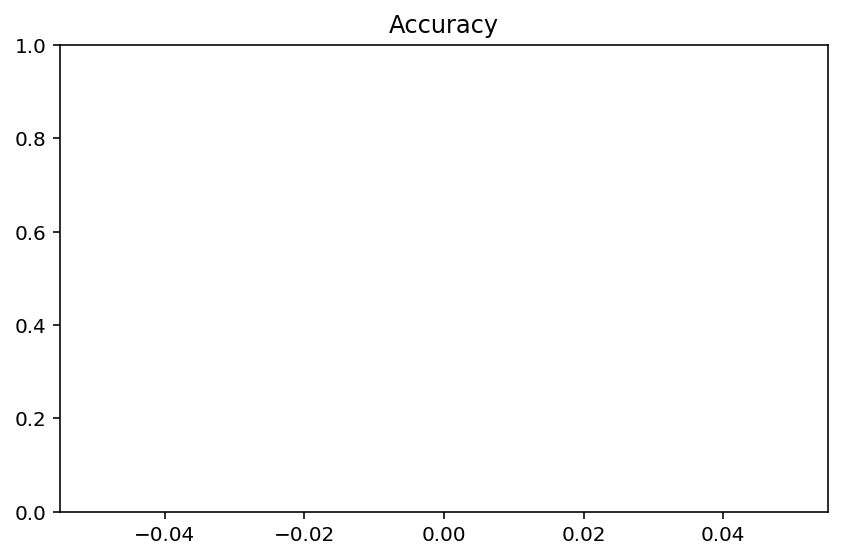

In [174]:
best_individ, population = execute(max_generations, population_size, mutation_rate)

## Test Model - MNIST

In [175]:
with tf.Session() as sess:
    net = Network(x_dim, 
                  n_classes,
                  best_individ.gene[0],
                  best_individ.gene[1], 
                  best_individ.gene[2], 
                  best_individ.gene[3])
    sess.run(tf.global_variables_initializer())

    values = []
    batch_num = mnist.test.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.test.next_batch(batch_size)
        # Run optimizers
        feed_dict = {net.x: train_batch,
                     net.y: labels}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.182993


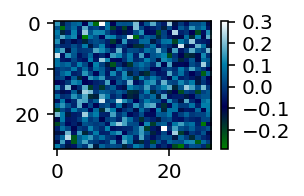

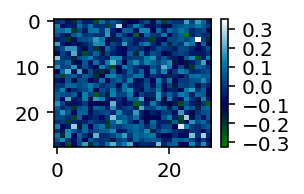

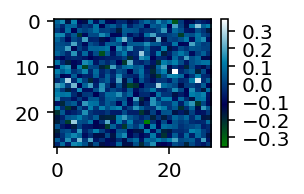

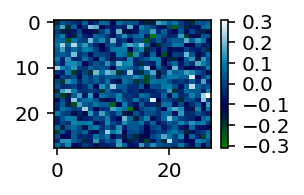

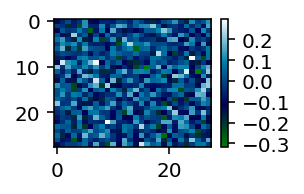

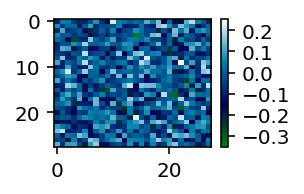

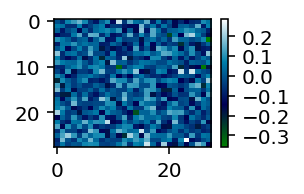

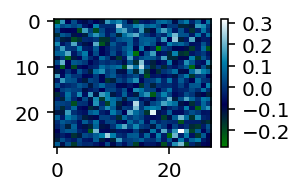

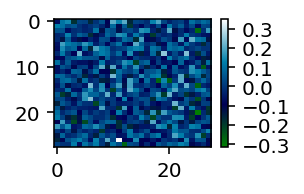

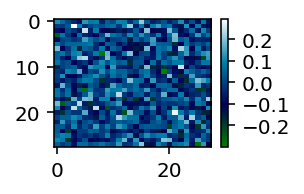

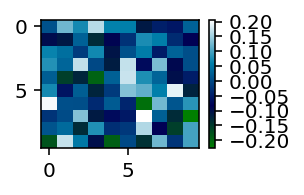

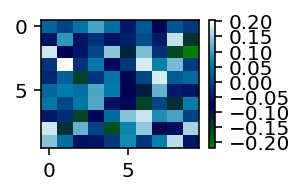

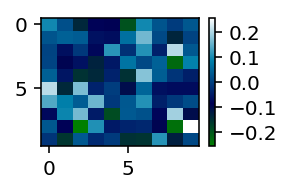

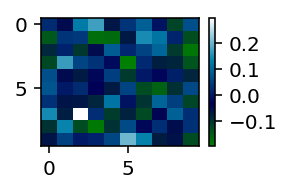

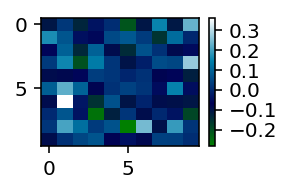

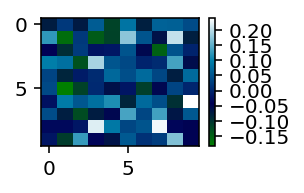

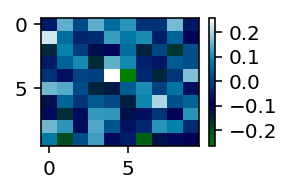

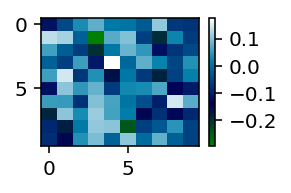

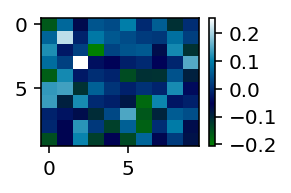

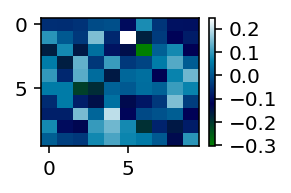

In [176]:
mat_a = np.reshape(best_individ.gene[0], (-1, 28, 28))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_a[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

mat_b = np.reshape(best_individ.gene[2], (-1, 10, 10))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_b[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

In [177]:
best_individ.gene[2]

array([[  9.58551267e-03,   1.25564353e-01,   7.44595365e-02,
          1.66025393e-01,   6.45438310e-02,   6.18260949e-02,
         -1.09868871e-01,  -4.50108605e-02,  -5.61607984e-02,
          2.97839770e-02],
       [ -9.40288050e-02,  -1.07121269e-01,   2.90587047e-02,
         -1.29749475e-01,  -8.62311400e-02,  -2.39102074e-02,
          7.69856610e-02,   6.03167334e-02,  -3.12223579e-02,
         -8.31305633e-02],
       [  6.78763587e-02,   4.45061962e-02,  -1.39137571e-02,
          7.30190694e-02,  -1.04567910e-01,   1.06980588e-02,
          5.95760742e-02,  -4.96956591e-02,   3.06947059e-02,
          7.47409121e-03],
       [  8.19416245e-02,   3.37112084e-02,   1.71040285e-01,
          4.44133943e-04,  -1.13256383e-01,   1.71741513e-01,
         -6.92800971e-02,   1.31087610e-01,  -9.02353979e-02,
          7.76082563e-03],
       [  2.55249247e-02,  -1.50713404e-01,  -1.23116261e-01,
         -1.91995802e-01,   2.71379577e-02,   1.74626446e-01,
          8.02064737e-02

## Euclidean Distance Matrix

0


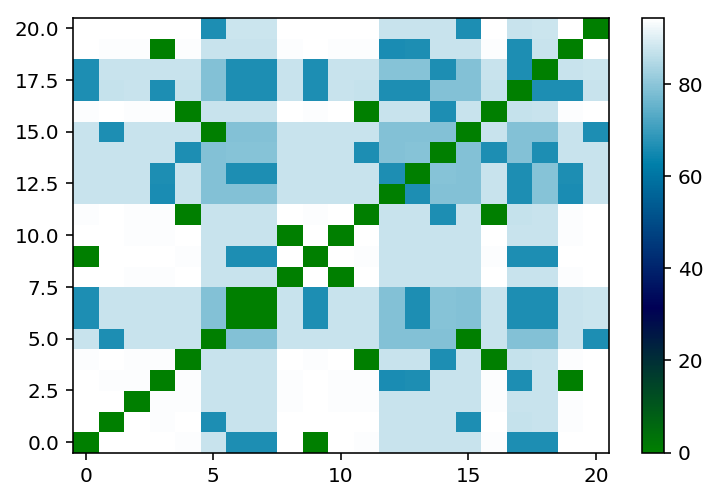

2


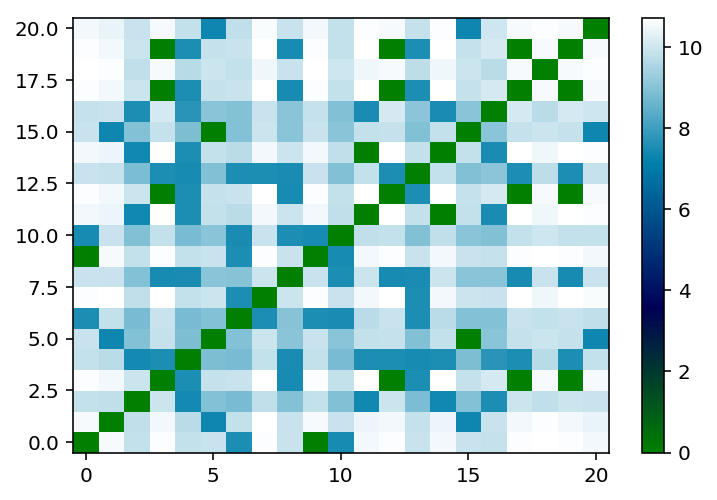

In [178]:
def compute_weights_distance(population, layer_id, layer_shape):
    population_size = len(population)
    distances = np.zeros((population_size, population_size), dtype=np.float32)

    print(layer_id)
    for ii, p in enumerate(population):
        for jj, q in enumerate(population):
            a = np.reshape(p.gene[layer_id], layer_shape)
            b = np.reshape(q.gene[layer_id], layer_shape)
            c = np.abs(a-b)
            c = np.sum(c)
            c = np.sqrt(c)
            distances[ii, jj] = c

    plt.imshow(distances, interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()
    
compute_weights_distance(population.population, 0, (784, 100))
compute_weights_distance(population.population, 2, (100, 10))